# Hamming weight and Pearson Correlation

This notebook demonstrates how to guess a floating number using Hamming Weight model.


We generate a random secret floating number. Then we use hamming weight model to guess the number.

We develop a method of devide-and-conquer to quickly arrive to a close number with a defined precision.

## Guessing...

In [1]:
import struct
import numpy as np
import pandas as pd
import random
from pprint import pprint
import hashlib
import binascii
from guess_range import *

In [2]:
def secret_signature(secret_numbers):
    m = hashlib.md5()
    m.update(secret_numbers)
    a = m.digest()
    s = 2
    n = [0] * s
    for idx in range(len(a)):
        i = idx % s
        n[i] = (n[i] + a[idx]) % 256
    return binascii.hexlify(bytes(n))        

In [3]:
def guess_number_range_stat(secret_number, guess_range, precision, known_input_size=1000):
    results = guess_number_range_subranges(secret_number, guess_range, precision, known_input_size)
    #
    # discard low correlation results
    corr_values = results[CORRELATION]
    results = results[corr_values > (corr_values.max() * 0.95)].sort_values(CORRELATION, ascending=False)
    guess_values = ((results[LOW_VALUE] + results[HIGH_VALUE]) / 2.0).round(decimals=int(-np.log10(precision)))    
    return results[~guess_values.duplicated(keep='first')]

In [4]:
SECRET_VALUE = 'secret value'

guess_range = (-5e0, 5e0)
precision = 1e-6
#
# initalize parameter and generate a random number (secret number)
known_input_size = 1000

## Test single point

In [5]:
# secret_number = random.uniform(guess_range[0] / 10, guess_range[1] / 10)
secret_number = -6.474345698712127e-2
#secret_number = np.round(secret_number, int(-np.log10(precision)))
print('secret_number = %.010f' % secret_number)

secret_number = -0.0647434570


In [6]:
%%time
single_results = guess_number_range_stat(secret_number, guess_range, precision, known_input_size)

searching in the range (-5.000000, 5.000000)
searching in the range (-0.500000, 0.500000)
searching in the range (-0.050000, 0.050000)
searching in the range (-0.005000, 0.005000)
searching in the range (-0.000500, 0.000500)
searching in the range (-0.000050, 0.000050)
searching in the range (-0.000005, 0.000005)
searching in the range (-0.000001, 0.000001)
CPU times: user 2min 25s, sys: 3.69 s, total: 2min 28s
Wall time: 2min 28s


In [7]:
single_results.sort_values(CORRELATION, ascending=False)

,input id,low value,high value,correlation
11,2.0,-0.064744,-0.064743,0.998177
4,0.0,-1.035895,-1.035895,0.991417
3,-1.0,-4.143581,-4.143581,0.981872
9,0.0,-0.258974,-0.258973,0.959881


In [8]:
guess_values = (single_results[LOW_VALUE] + single_results[HIGH_VALUE]) / 2.0
error_rates = ((guess_values - secret_number) / secret_number).abs() * 100.0
pprint(error_rates)
guessed_number = guess_values[error_rates.idxmin()]    
pprint('the secret number = %f' % secret_number)
pprint('the guessed number = %f' % guessed_number)
pprint('best correlation = %f' % single_results[CORRELATION][error_rates.idxmin()])
pprint('error rate = %0.6f%s' % (error_rates.min(), '%'))

11       0.000096
4     1499.999595
3     6299.999761
9      299.999646
dtype: float64
'the secret number = -0.064743'
'the guessed number = -0.064744'
'best correlation = 0.998177'
'error rate = 0.000096%'


In [9]:
known_inputs = np.random.uniform(-1e2, 1e2, 1000)
secret_hw = pd.Series(np.vectorize(hamming_weight)(known_inputs * secret_number))
print('guess_range = %s' % str(guess_range))
guess_number_range(secret_hw, guess_range, precision, known_inputs)

guess_range = (-5.0, 5.0)


(-0.0647437572479248, -0.06474316120147705, 0.989646007945065)

## Test multiple points

In [10]:
multiple_results = pd.DataFrame()

In [11]:
n_secret_numbers = 200
secret_numbers = np.concatenate((
    np.random.uniform(guess_range[0], guess_range[1], int(n_secret_numbers*2/4) ),
    np.random.uniform(guess_range[0]*3e-1, guess_range[1]*3e-1, int(n_secret_numbers*1/4)),
    np.random.uniform(guess_range[0]*1e-1, guess_range[1]*1e-1, int(n_secret_numbers*1/4))
))
np.random.shuffle(secret_numbers)
print('secret_numbers.shape = %s' % (str(secret_numbers.shape)))

secret_numbers.shape = (200,)


In [12]:
%%time
loops = 0
for idx in secret_numbers:
    # if the number is already treated, the ignore it
    if (SECRET_VALUE in multiple_results.columns) and (idx in multiple_results[SECRET_VALUE].values):
        continue    
    results = guess_number_range_stat(idx, guess_range, precision, known_input_size)
    results[SECRET_VALUE] = idx
    pprint('=' * 20)
    pprint(results)
    guess_values = (results[LOW_VALUE] + results[HIGH_VALUE]) / 2.0
    multiple_results = pd.concat([multiple_results, results], axis=0, ignore_index=True)
    loops = loops + 1

searching in the range (-5.000000, 5.000000)
searching in the range (-0.500000, 0.500000)
searching in the range (-0.050000, 0.050000)
searching in the range (-0.005000, 0.005000)
searching in the range (-0.000500, 0.000500)
searching in the range (-0.000050, 0.000050)
searching in the range (-0.000005, 0.000005)
searching in the range (-0.000001, 0.000001)
'===================='
    input id  low value  high value  correlation  secret value
12       0.0   0.038105    0.038106     0.981866      0.609681
1       -1.0   2.438724    2.438725     0.966144      0.609681
5        1.0  -0.609682   -0.609681     0.956566      0.609681
searching in the range (-5.000000, 5.000000)
searching in the range (-0.500000, 0.500000)
searching in the range (-0.050000, 0.050000)
searching in the range (-0.005000, 0.005000)
searching in the range (-0.000500, 0.000500)
searching in the range (-0.000050, 0.000050)
searching in the range (-0.000005, 0.000005)
searching in the range (-0.000001, 0.000001)
'====

searching in the range (-0.500000, 0.500000)
searching in the range (-0.050000, 0.050000)
searching in the range (-0.005000, 0.005000)
searching in the range (-0.000500, 0.000500)
searching in the range (-0.000050, 0.000050)
searching in the range (-0.000005, 0.000005)
searching in the range (-0.000001, 0.000001)
'===================='
   input id  low value  high value  correlation  secret value
0      -2.0   2.575246    2.575247     0.999848      2.575246
6      -1.0   0.160953    0.160954     0.978279      2.575246
4       0.0  -2.575247   -2.575246     0.963092      2.575246
searching in the range (-5.000000, 5.000000)
searching in the range (-0.500000, 0.500000)
searching in the range (-0.050000, 0.050000)
searching in the range (-0.005000, 0.005000)
searching in the range (-0.000500, 0.000500)
searching in the range (-0.000050, 0.000050)
searching in the range (-0.000005, 0.000005)
searching in the range (-0.000001, 0.000001)
'===================='
    input id  low value  high v

searching in the range (-0.050000, 0.050000)
searching in the range (-0.005000, 0.005000)
searching in the range (-0.000500, 0.000500)
searching in the range (-0.000050, 0.000050)
searching in the range (-0.000005, 0.000005)
searching in the range (-0.000001, 0.000001)
'===================='
    input id  low value  high value  correlation  secret value
11       2.0  -0.380606   -0.380605     1.000000     -0.380605
8        1.0   0.380605    0.380606     0.962648     -0.380605
searching in the range (-5.000000, 5.000000)
searching in the range (-0.500000, 0.500000)
searching in the range (-0.050000, 0.050000)
searching in the range (-0.005000, 0.005000)
searching in the range (-0.000500, 0.000500)
searching in the range (-0.000050, 0.000050)
searching in the range (-0.000005, 0.000005)
searching in the range (-0.000001, 0.000001)
'===================='
    input id  low value  high value  correlation  secret value
2        0.0   3.076420    3.076420     0.999929       3.07642
14       

searching in the range (-0.000001, 0.000001)
'===================='
   input id  low value  high value  correlation  secret value
5       1.0  -0.971265   -0.971265     0.999953     -0.971265
3      -1.0  -3.885061   -3.885061     0.975270     -0.971265
4       0.0  -1.942531   -1.942530     0.968255     -0.971265
9       0.0  -0.242817   -0.242816     0.961815     -0.971265
searching in the range (-5.000000, 5.000000)
searching in the range (-0.500000, 0.500000)
searching in the range (-0.050000, 0.050000)
searching in the range (-0.005000, 0.005000)
searching in the range (-0.000500, 0.000500)
searching in the range (-0.000050, 0.000050)
searching in the range (-0.000005, 0.000005)
searching in the range (-0.000001, 0.000001)
'===================='
    input id  low value  high value  correlation  secret value
11       2.0  -0.037695   -0.037694     0.993993     -0.037694
4        0.0  -0.603110   -0.603109     0.984907     -0.037694
10       1.0  -0.150778   -0.150777     0.967857  

searching in the range (-0.500000, 0.500000)
searching in the range (-0.050000, 0.050000)
searching in the range (-0.005000, 0.005000)
searching in the range (-0.000500, 0.000500)
searching in the range (-0.000050, 0.000050)
searching in the range (-0.000005, 0.000005)
searching in the range (-0.000001, 0.000001)
'===================='
   input id  low value  high value  correlation  secret value
4       0.0  -3.545342   -3.545341     1.000000     -3.545342
2       0.0   3.545341    3.545342     0.964857     -3.545342
searching in the range (-5.000000, 5.000000)
searching in the range (-0.500000, 0.500000)
searching in the range (-0.050000, 0.050000)
searching in the range (-0.005000, 0.005000)
searching in the range (-0.000500, 0.000500)
searching in the range (-0.000050, 0.000050)
searching in the range (-0.000005, 0.000005)
searching in the range (-0.000001, 0.000001)
'===================='
   input id  low value  high value  correlation  secret value
2       0.0   4.516602    4.516

searching in the range (-0.000005, 0.000005)
searching in the range (-0.000001, 0.000001)
'===================='
   input id  low value  high value  correlation  secret value
5       1.0  -0.422500   -0.422499     0.996988     -0.422499
4       0.0  -1.689998   -1.689997     0.983332     -0.422499
8       1.0   0.422499    0.422500     0.964644     -0.422499
searching in the range (-5.000000, 5.000000)
searching in the range (-0.500000, 0.500000)
searching in the range (-0.050000, 0.050000)
searching in the range (-0.005000, 0.005000)
searching in the range (-0.000500, 0.000500)
searching in the range (-0.000050, 0.000050)
searching in the range (-0.000005, 0.000005)
searching in the range (-0.000001, 0.000001)
'===================='
   input id  low value  high value  correlation  secret value
4       0.0  -1.506459   -1.506458     0.999394     -1.506458
9       0.0  -0.376615   -0.376614     0.973321     -1.506458
searching in the range (-5.000000, 5.000000)
searching in the range (-

searching in the range (-0.500000, 0.500000)
searching in the range (-0.050000, 0.050000)
searching in the range (-0.005000, 0.005000)
searching in the range (-0.000500, 0.000500)
searching in the range (-0.000050, 0.000050)
searching in the range (-0.000005, 0.000005)
searching in the range (-0.000001, 0.000001)
'===================='
    input id  low value  high value  correlation  secret value
8        1.0   0.411016    0.411016     0.997373      0.411016
2        0.0   1.644062    1.644063     0.981131      0.411016
5        1.0  -0.411016   -0.411015     0.963110      0.411016
10       1.0  -0.411016   -0.411016     0.960353      0.411016
searching in the range (-5.000000, 5.000000)
searching in the range (-0.500000, 0.500000)
searching in the range (-0.050000, 0.050000)
searching in the range (-0.005000, 0.005000)
searching in the range (-0.000500, 0.000500)
searching in the range (-0.000050, 0.000050)
searching in the range (-0.000005, 0.000005)
searching in the range (-0.00000

searching in the range (-0.500000, 0.500000)
searching in the range (-0.050000, 0.050000)
searching in the range (-0.005000, 0.005000)
searching in the range (-0.000500, 0.000500)
searching in the range (-0.000050, 0.000050)
searching in the range (-0.000005, 0.000005)
searching in the range (-0.000001, 0.000001)
'===================='
   input id  low value  high value  correlation  secret value
2       0.0   2.356459    2.356459     0.999540      2.356459
4       0.0  -2.356459   -2.356459     0.960995      2.356459
6      -1.0   0.147278    0.147279     0.959260      2.356459
searching in the range (-5.000000, 5.000000)
searching in the range (-0.500000, 0.500000)
searching in the range (-0.050000, 0.050000)
searching in the range (-0.005000, 0.005000)
searching in the range (-0.000500, 0.000500)
searching in the range (-0.000050, 0.000050)
searching in the range (-0.000005, 0.000005)
searching in the range (-0.000001, 0.000001)
'===================='
   input id  low value  high va

searching in the range (-0.000001, 0.000001)
'===================='
   input id  low value  high value  correlation  secret value
2       0.0   1.981361    1.981362     0.999919      1.981361
7       0.0   0.123835    0.123836     0.988399      1.981361
searching in the range (-5.000000, 5.000000)
searching in the range (-0.500000, 0.500000)
searching in the range (-0.050000, 0.050000)
searching in the range (-0.005000, 0.005000)
searching in the range (-0.000500, 0.000500)
searching in the range (-0.000050, 0.000050)
searching in the range (-0.000005, 0.000005)
searching in the range (-0.000001, 0.000001)
'===================='
   input id  low value  high value  correlation  secret value
2       0.0   3.561851    3.561851     0.999965      3.561851
6      -1.0   0.222615    0.222616     0.969890      3.561851
4       0.0  -3.561851   -3.561851     0.966888      3.561851
searching in the range (-5.000000, 5.000000)
searching in the range (-0.500000, 0.500000)
searching in the range (-

searching in the range (-0.000001, 0.000001)
'===================='
    input id  low value  high value  correlation  secret value
8        1.0   0.212604    0.212605     0.996624      0.212604
0       -2.0   0.850416    0.850416     0.966462      0.212604
10       1.0  -0.212605   -0.212604     0.947524      0.212604
searching in the range (-5.000000, 5.000000)
searching in the range (-0.500000, 0.500000)
searching in the range (-0.050000, 0.050000)
searching in the range (-0.005000, 0.005000)
searching in the range (-0.000500, 0.000500)
searching in the range (-0.000050, 0.000050)
searching in the range (-0.000005, 0.000005)
searching in the range (-0.000001, 0.000001)
'===================='
   input id  low value  high value  correlation  secret value
2       0.0   4.424239    4.424239     1.000000      4.424239
6      -1.0   0.276514    0.276515     0.982504      4.424239
4       0.0  -4.424239   -4.424239     0.961459      4.424239
searching in the range (-5.000000, 5.000000)
sear

searching in the range (-0.500000, 0.500000)
searching in the range (-0.050000, 0.050000)
searching in the range (-0.005000, 0.005000)
searching in the range (-0.000500, 0.000500)
searching in the range (-0.000050, 0.000050)
searching in the range (-0.000005, 0.000005)
searching in the range (-0.000001, 0.000001)
'===================='
   input id  low value  high value  correlation  secret value
5       1.0  -0.498468   -0.498468     0.999609     -0.498468
4       0.0  -1.993873   -1.993873     0.984355     -0.498468
8       1.0   0.498467    0.498468     0.958894     -0.498468
searching in the range (-5.000000, 5.000000)
searching in the range (-0.500000, 0.500000)
searching in the range (-0.050000, 0.050000)
searching in the range (-0.005000, 0.005000)
searching in the range (-0.000500, 0.000500)
searching in the range (-0.000050, 0.000050)
searching in the range (-0.000005, 0.000005)
searching in the range (-0.000001, 0.000001)
'===================='
   input id  low value  high va

searching in the range (-0.000500, 0.000500)
searching in the range (-0.000050, 0.000050)
searching in the range (-0.000005, 0.000005)
searching in the range (-0.000001, 0.000001)
'===================='
   input id  low value  high value  correlation  secret value
0      -2.0   1.187696    1.187697     1.000000      1.187697
7       0.0   0.296924    0.296925     0.976379      1.187697
searching in the range (-5.000000, 5.000000)
searching in the range (-0.500000, 0.500000)
searching in the range (-0.050000, 0.050000)
searching in the range (-0.005000, 0.005000)
searching in the range (-0.000500, 0.000500)
searching in the range (-0.000050, 0.000050)
searching in the range (-0.000005, 0.000005)
searching in the range (-0.000001, 0.000001)
'===================='
    input id  low value  high value  correlation  secret value
8        1.0   0.264807    0.264808     0.995949      0.264808
0       -2.0   4.236920    4.236921     0.985980      0.264808
10       1.0  -0.264808   -0.264807    

KeyboardInterrupt: 

### Save data

In [13]:
from datetime import datetime
multiple_results_fname = 'multiple_results-%s_%s.csv' % (datetime.now().strftime("%Y%m%d"), secret_signature(secret_numbers).decode('utf8'))
multiple_results.to_csv(multiple_results_fname)
pprint('multiple_results_fname = %s' % multiple_results_fname)

'multiple_results_fname = multiple_results-20200527_c13c.csv'


### Load data

In [14]:
# multiple_results_fname = 'multiple_results-20200523_011136.csv'
multiple_results = pd.read_csv(multiple_results_fname, index_col=0)
pprint('multiple_results_fname = %s' % multiple_results_fname)
multiple_results

'multiple_results_fname = multiple_results-20200527_c13c.csv'


,input id,low value,high value,correlation,secret value
0,0.0,0.038105,0.038106,0.981866,0.609681
1,-1.0,2.438724,2.438725,0.966144,0.609681
2,1.0,-0.609682,-0.609681,0.956566,0.609681
3,0.0,-2.157917,-2.157916,0.996799,-2.157917
4,0.0,2.157917,2.157918,0.949308,-2.157917
...,...,...,...,...,...
423,-1.0,0.068936,0.068937,0.962935,1.102985
424,0.0,0.004308,0.004309,0.960866,1.102985
425,1.0,-1.102986,-1.102985,0.947421,1.102985
426,-1.0,-2.528503,-2.528502,0.999923,-2.528502


### Hit targets and missed targets

In [15]:
#
# compute the number of secret values which are present in guessed ranges
n_identified_ranges = multiple_results.groupby(SECRET_VALUE).apply(lambda x: ((x[LOW_VALUE]<=x[SECRET_VALUE]) & (x[SECRET_VALUE]<=x[HIGH_VALUE])).any())
counts = n_identified_ranges.value_counts()
if True in counts.index:
    pprint('The number of identified values: %d/%d' % (counts[True], counts.sum()))
if False in counts.index:
    pprint('The number of missed values: %d/%d' % (counts[False], counts.sum()))

'The number of identified values: 143/151'
'The number of missed values: 8/151'


In [16]:
df = multiple_results.loc[multiple_results.groupby(SECRET_VALUE)[CORRELATION].idxmax()]
df['guess_values'] = (df[LOW_VALUE] + df[HIGH_VALUE]) / 2.0
df['error_rate'] = ((df['guess_values'] - df[SECRET_VALUE])/df[SECRET_VALUE]).abs()
df.sort_values('error_rate')

,input id,low value,high value,correlation,secret value,guess_values,error_rate
83,-2.0,0.437415,0.437416,0.999484,0.437416,0.437416,8.121937e-10
137,1.0,-1.235961,-1.235960,0.999447,-1.235960,-1.235960,9.963841e-10
69,-1.0,-3.552105,-3.552104,0.999588,-3.552105,-3.552105,1.880285e-09
144,0.0,4.141876,4.141877,1.000000,4.141876,4.141876,2.189342e-09
303,0.0,3.561851,3.561851,0.999965,3.561851,3.561851,2.339123e-09
...,...,...,...,...,...,...,...
100,0.0,1.948334,1.948335,0.995442,0.121771,1.948334,1.500000e+01
173,-2.0,2.472703,2.472704,0.982001,0.154544,2.472704,1.500000e+01
260,-1.0,1.522010,1.522011,0.988827,0.095126,1.522010,1.500000e+01
236,-1.0,-3.961463,-3.961462,0.979652,-0.061898,-3.961463,6.300000e+01


### Graphs of the first choices

In [17]:
first_choice_results = multiple_results.loc[multiple_results.groupby(SECRET_VALUE)[CORRELATION].idxmax()]
guess_values = (first_choice_results[LOW_VALUE] + first_choice_results[HIGH_VALUE]) / 2.0
guess_values.index = first_choice_results[SECRET_VALUE]
guess_values.sort_index(inplace=True)
error_rate = ((guess_values - guess_values.index)/guess_values.index).abs()
(error_rate < precision).value_counts()

True     123
False     28
dtype: int64

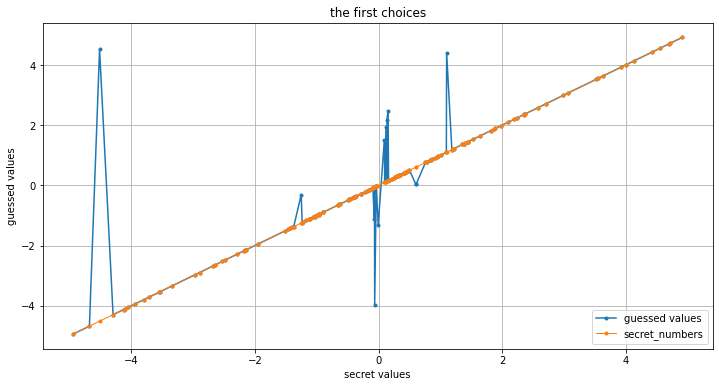

In [18]:
ax = guess_values.plot(figsize = (12, 6), marker='.', label='guessed values')
ax.plot(guess_values.index, guess_values.index, marker='.', linewidth=1, label='secret_numbers')
ax.legend()
ax.set_xlabel('secret values')
ax.set_ylabel('guessed values')
ax.set_title('the first choices')
ax.grid(True)

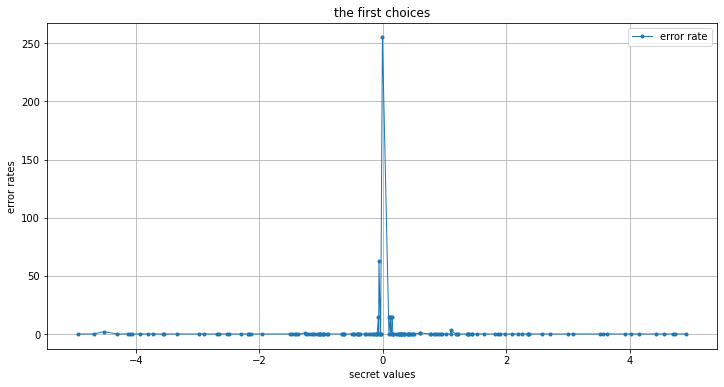

In [19]:
ax = error_rate.plot(figsize = (12, 6), label='error rate', marker='.', linewidth=1)
ax.legend()
ax.set_xlabel('secret values')
ax.set_ylabel('error rates')
ax.set_title('the first choices')
ax.grid(True)

### Graphs of the second choice

In [20]:
pprint('The total number of the second choices is: %d' % (multiple_results.groupby(SECRET_VALUE).size().prod()-1))

'The total number of the second choices is: -1'


In [21]:
guess_values = ((multiple_results[LOW_VALUE] + multiple_results[HIGH_VALUE]) / 2.0)
error_rate = ((guess_values - multiple_results[SECRET_VALUE])/multiple_results[SECRET_VALUE]).abs()
second_choice_results = multiple_results.loc[error_rate.groupby(multiple_results[SECRET_VALUE]).idxmin()]
guess_values = ((second_choice_results[LOW_VALUE] + second_choice_results[HIGH_VALUE]) / 2.0)
guess_values.index = second_choice_results[SECRET_VALUE]
guess_values.sort_index(inplace=True)

error_rate = ((guess_values - guess_values.index)/guess_values.index).abs()
(error_rate < 1e-3).value_counts()

True     146
False      5
dtype: int64

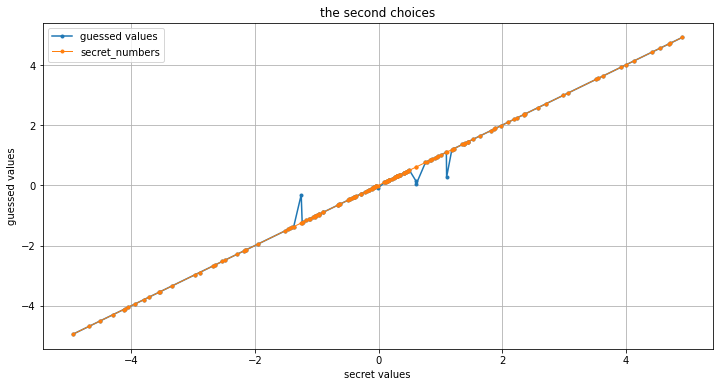

In [22]:
ax = guess_values.plot(figsize = (12, 6), marker='.', label='guessed values')
ax.plot(guess_values.index, guess_values.index, marker='.', linewidth=1, label='secret_numbers')
ax.legend()
ax.set_xlabel('secret values')
ax.set_ylabel('guessed values')
ax.set_title('the second choices')
ax.grid(True)

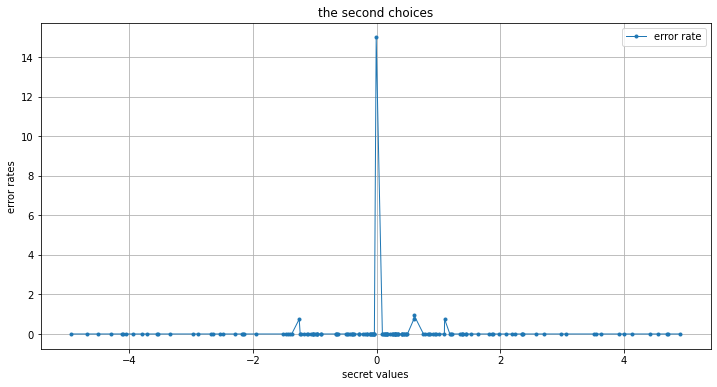

In [23]:
ax = error_rate.plot(figsize = (12, 6), label='error rate', marker='.', linewidth=1)
ax.legend()
ax.set_xlabel('secret values')
ax.set_ylabel('error rates')
ax.set_title('the second choices')
ax.grid(True)

# Batina method

In [24]:
def batina_guess_number(secret_number, guess_range, precision, known_inputs):
    low, high = guess_range
    guess_val = np.arange(low, high, precision)
    hw = pd.DataFrame(columns=guess_val,
                        data=np.vectorize(hamming_weight)(known_inputs.reshape(-1, 1) * guess_val))
    hw['actual'] = np.vectorize(hamming_weight)(known_inputs * secret_number)
    return hw.corr(method='pearson')['actual'].drop('actual').idxmax()

In [25]:
batinta_results = pd.Series(name='guessed_numbers', dtype=np.float32)

In [26]:
# we have to define a low precision, otherwise, it takes too long time to run
precision = 1e-3
known_inputs = np.random.uniform(-1e1, 1e1, 1000)

In [27]:
%%time
for idx in secret_numbers:
    if idx in batinta_results.index:
        continue    
    batinta_results[idx] = batina_guess_number(idx, guess_range, precision, known_inputs)
    print('secret_value = %f, guessed_value = %f' % (idx, batinta_results[idx]))
batinta_results.sort_index(inplace=True)    

secret_value = 0.609681, guessed_value = 0.610000
secret_value = -2.157917, guessed_value = -2.158000


KeyboardInterrupt: 

### Save data

In [28]:
from datetime import datetime
batinta_results_fname = 'batinta_results-%s_%s.csv' % (datetime.now().strftime("%Y%m%d"), secret_signature(secret_numbers).decode('utf8'))
batinta_results.to_csv(batinta_results_fname)
pprint('batinta_results_fname = %s' % batinta_results_fname)

'batinta_results_fname = batinta_results-20200527_c13c.csv'


### Load data

In [29]:
# batinta_results_fname = 'batinta_results-%s.csv' % '20200522_071337'
batinta_results = pd.read_csv(batinta_results_fname, index_col=0, squeeze=True)
batinta_results.sort_index(inplace=True)    
batinta_results

-2.157917   -2.158
 0.609681    0.610
Name: guessed_numbers, dtype: float64

### Graphs

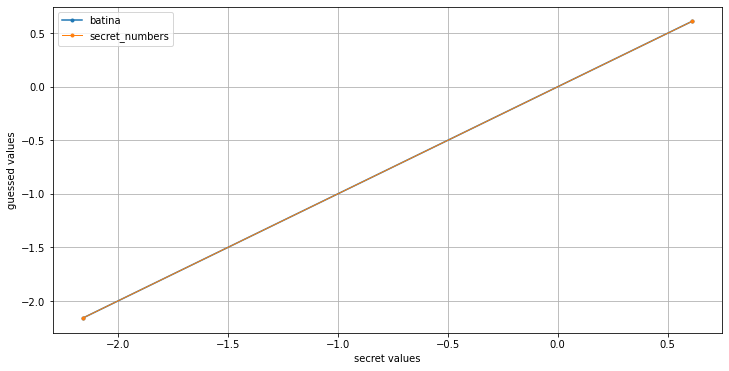

In [30]:
ax = batinta_results.plot(figsize = (12, 6), marker='.', label='batina')
#results.plot(ax=ax, marker='.', label='bxlab')
ax.plot(batinta_results.index, batinta_results.index, marker='.', linewidth=1, label='secret_numbers')
ax.legend()
ax.set_xlabel('secret values')
ax.set_ylabel('guessed values')
ax.grid(True)

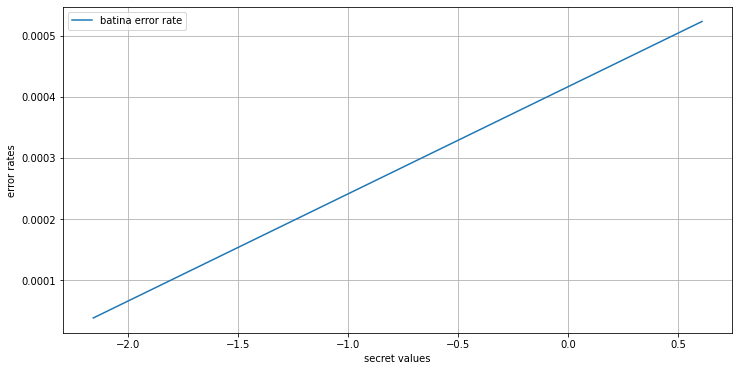

In [31]:
batina_error_rate = ((batinta_results - batinta_results.index)/batinta_results.index).abs()
ax = batina_error_rate.plot(figsize = (12, 6), label='batina error rate')
#ax = error_rate.plot(ax=ax, label='error rate')
ax.legend()
ax.set_xlabel('secret values')
ax.set_ylabel('error rates')
ax.grid(True)

In [32]:
batina_error_rate[batina_error_rate > 0.10]

Series([], dtype: float64)

In [33]:
####
# number of correctly guessed values / number of wrong values
###
(batina_error_rate < precision).value_counts()

NameError: name 'prescision' is not defined

# Annex

In [ ]:
def annex_compute_corr(secret_hw, guess_range, known_inputs, guess_val_size=1000):
    low, high = guess_range
    guess_val = np.arange(low, high, (high - low) / (guess_val_size - 1e-5))
    hw = pd.DataFrame(columns=guess_val,
                        data=np.vectorize(hamming_weight)(known_inputs.reshape(-1, 1) * guess_val))
    return hw.corrwith(pd.Series(secret_hw), method='pearson')

In [ ]:
guess_range=(-3e0, 3e0)
# the number of guess values in the guess range
guess_val_size=4000
# generate the known inputs which is used to test the guess values
known_inputs = np.random.uniform(-1e2, 1e2, 1000)

secret_number = random.uniform(guess_range[0], guess_range[1]) 
secret_number = 6.374345698e-2
print('secret_number =', secret_number)

secret_hw = np.vectorize(hamming_weight)(known_inputs * secret_number)
correlations = annex_compute_corr(secret_hw, guess_range, known_inputs, guess_val_size)
correlations_1 = annex_compute_corr(secret_hw, guess_range, known_inputs, int(guess_val_size*10))
correlations_2 = annex_compute_corr(secret_hw, guess_range, known_inputs, int(guess_val_size/10))
correlations.sort_values(ascending=False).iloc[:10]

In [ ]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 20))
correlations_1.plot(ax=ax[0], label='corr-%s' % correlations_1.shape[0], color='green')
correlations.plot(ax=ax[0], label='corr-%s' % correlations.shape[0], color='magenta')
correlations_2.plot(ax=ax[0], label='corr-%s' % correlations_2.shape[0], color='yellow')
ax[0].vlines(secret_number, correlations.min(), correlations.max(), color='red')

correlations_1.plot(ax=ax[1], label='corr-%s' % correlations_1.shape[0], color='green')
ax[1].vlines(secret_number, correlations_1.min(), correlations_1.max(), color='red')

correlations.plot(ax=ax[2], label='corr-%s' % correlations.shape[0], color='magenta')
ax[2].vlines(secret_number, correlations.min(), correlations.max(), color='red')

correlations_2.plot(ax=ax[3], label='corr-%s' % correlations_2.shape[0], color='yellow')
ax[3].vlines(secret_number, correlations_2.min(), correlations_2.max(), color='red')

for a in ax:
    a.legend()
    a.grid(True)
    a.set_xlabel('guess numbers')
    a.set_ylabel('HW correlations')
    
plt.show()

## Analyze with noise - one number

In [60]:
def resize_known_inputs(known_inputs, new_len):
    """
    resize the known input to the new_len
    :param known_inputs: known inputs 
    :param new_len: new size of the know_inputs
    :return: the known
    """
    old_len = len(known_inputs)
    vf = np.vectorize(lambda i: known_inputs[int(i*old_len/new_len)])
    return vf(np.arange(0, new_len))

def add_noise_to_signal(signal, snr):
    """
    add noise to the signal
    :param signal: signal
    :param snr: signal to noise ratio 
    :return: signal with noise
    """
    return (signal + np.random.normal(-0.5, 0.5, len(signal))*(np.max(signal)-np.min(signal))*(1.0-snr))

In [ ]:
# the noise frequency is 50 times higher than HW signal frequency. Here we also increase
# the sizes of the computation with 
noise_known_inputs = resize_known_inputs(known_inputs, len(known_inputs) * 50)
no_noise_secret_hw = np.vectorize(hamming_weight)(noise_known_inputs * secret_number)

In [ ]:
### Add noise to hamming weight of the multiplication of the secret number
signal_to_noise_ratio = 0.5
noise_secret_hw = add_noise_to_signal(signal=no_noise_secret_hw, snr=signal_to_noise_ratio)
ax = pd.DataFrame([noise_secret_hw, no_noise_secret_hw], index=['noise_secret_hw', 'no_noise_secret_hw']).T.plot(figsize=(15,6))
ax.legend()

In [ ]:
noise_correlations = annex_compute_corr(noise_secret_hw, guess_range, noise_known_inputs, guess_val_size)
print('secret_number =', secret_number)
noise_correlations.sort_values(ascending=False).iloc[:10]

In [ ]:
ax = correlations.plot(figsize=(15, 6), label='without noise')
noise_correlations.plot(ax=ax, label='with noise')
ax.vlines(secret_number, 
          min(noise_correlations.min(), correlations.min()),
          max(noise_correlations.max(), correlations.max()), 
          color='red', label='secret value')
ax.legend()

## Analyze with noise - multiple numbers

In [65]:
noise_results = pd.DataFrame()

In [66]:
noise_known_input_set = generate_known_inputs(exps=(-2,3), nsize=3000)
noise_precision = 1e-6
noise_n_secret_numbers = 20
noise_secret_numbers = np.concatenate((
    np.random.uniform(guess_range[0], guess_range[1], int(noise_n_secret_numbers*2/4) ),
    np.random.uniform(guess_range[0]*3e-1, guess_range[1]*3e-1, int(noise_n_secret_numbers*1/4)),
    np.random.uniform(guess_range[0]*1e-1, guess_range[1]*1e-1, int(noise_n_secret_numbers*1/4))
))
np.random.shuffle(secret_numbers)
print('secret_numbers.shape = %s' % (str(secret_numbers.shape)))

secret_numbers.shape = (20,)


In [67]:
noise_secret_numbers_hws = {}
for idx in noise_known_input_set.index:
    noise_secret_numbers_hws[idx] = pd.DataFrame(columns=noise_secret_numbers, data=np.vectorize(hamming_weight)(np.asarray(noise_known_input_set.loc[idx]).reshape(-1, 1) * noise_secret_numbers))

In [68]:
### Add noise to hamming weight of the multiplication of the secret number
signal_to_noise_ratio = 0.5

noise_secret_numbers_hws_with_noise = {}
for k in noise_secret_numbers_hws.keys():
    noise_secret_numbers_hws_with_noise[k] = noise_secret_numbers_hws[k].apply(lambda hw: add_noise_to_signal(signal=hw, snr=signal_to_noise_ratio), axis=0)

In [71]:
noise_secret_numbers_hws[-1]

,4.085629,-3.702981,-4.730199,-3.825507,3.861351,1.060059,-4.358912,-1.648132,-1.945527,3.549336,0.790900,0.562727,-0.016480,-0.697483,-0.402612,0.356170,0.250556,-0.047118,-0.131494,0.459661
0,22,16,20,22,18,23,20,15,15,17,16,18,17,15,15,23,17,15,17,15
1,15,19,16,14,18,16,14,20,17,14,18,14,20,18,15,15,15,20,19,15
2,16,19,16,21,20,13,13,17,16,21,17,18,18,18,14,16,14,18,17,16
3,15,17,16,15,19,20,18,13,17,16,17,19,17,15,15,18,18,19,20,18
4,15,23,18,16,19,16,17,17,20,16,20,18,17,13,14,18,15,13,17,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,20,13,15,16,21,14,16,16,17,17,16,16,14,20,18,17,18,18,15,14
496,14,18,15,16,17,12,19,19,17,20,17,16,13,20,20,17,15,15,16,17
497,13,20,18,21,17,16,19,20,21,17,14,16,19,20,18,16,12,17,13,17
498,17,17,17,20,17,17,19,20,23,17,20,17,19,16,18,13,17,13,12,13
